In [1]:
# brew install graphviz
# pip install pygraphviz
import pygraphviz as pgv
from IPython.display import Image, SVG, display
import networkx as nx

def draw(graph):
    svg = nx.nx_agraph.to_agraph(graph).draw(prog='dot',format='svg')
    display(SVG(svg))

### Study question 3.4.1:

Assume that in Figure 3.8, only $X$, $Y$, and one additional variable can be measured. Which variable would allow the identification of the effect of $X$ on $Y$? What would the effect be?
<hr>

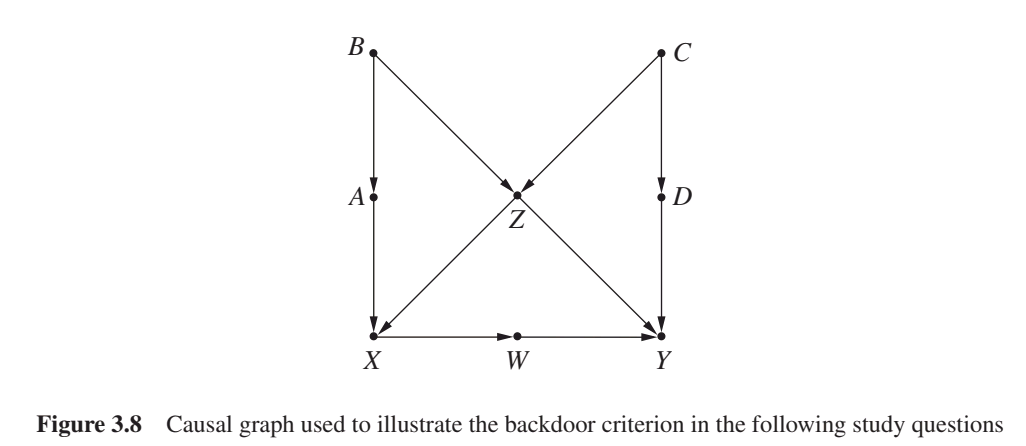

**Answer:** $W$. Goal is to show that $W$ satisfies the front-door criterion.

Recall that the front-door criterion is satisfied for a set of variables Z relativel to an ordered pair of variables $(X, Y)$ when:

1. $Z$ intercepts all _directed_ paths from $X$ to $Y$.
2. There is no unblocked _backdoor_ path from $X$ to $Z$. Recall that a path is blocked by $Z$ when the path contains a collider not in $Z$ and has no descendants in $Z$, or a chain/fork whose middle node is in $Z$.
3. All backdoor paths from $Z$ to $Y$ are blocked by $X$.

Let $Z=\{W\}$. Then (1) is clearly satisfied, since there is only one directed path.

For (2), every backdoor path from X to W must contain one of the segments $Z\to Y \leftarrow W$ or $D\to Y \leftarrow W$. These are both colliders, which therefore block the path.

For (3), similarly, every backdoor path from W to Y must contain the chains $W\to X\to Z$ or $W\to X \to A$, which are blocked by $X$.

### Study Question 3.4.2:
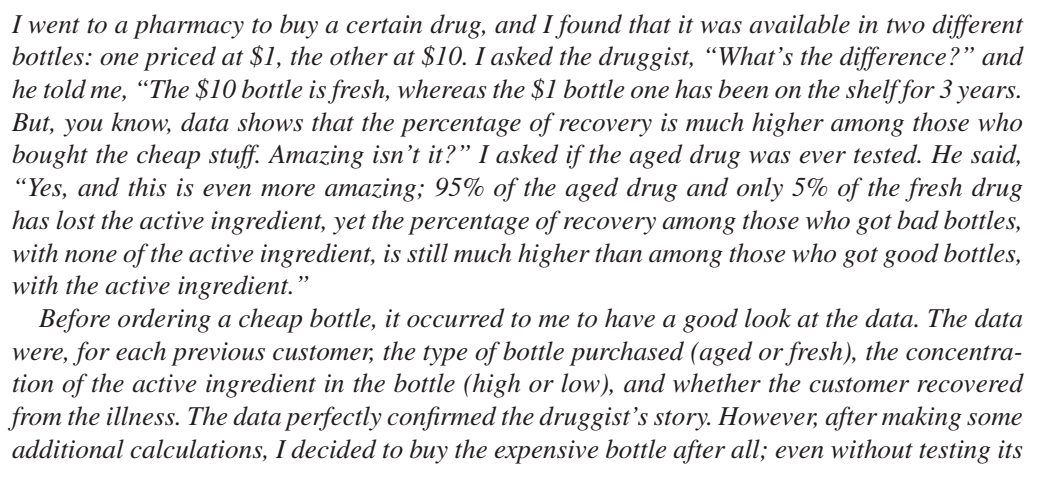
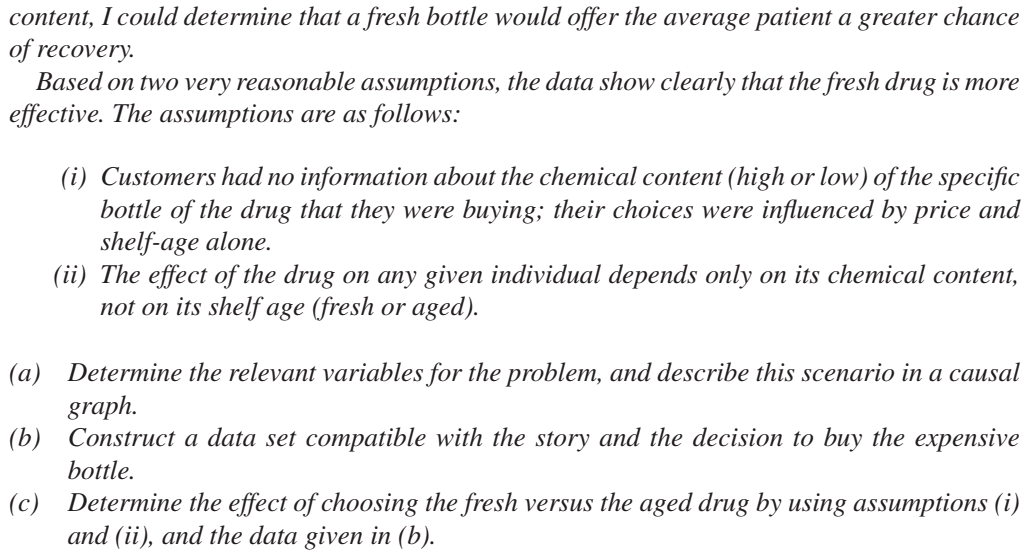

**Answer (a)**: That makes sense if add an unobserved confounder $S$ (severity of disease). Severe disease reduces the probability of recovery and increases the probability of buying the more expensive drug (since the symptoms are worse).

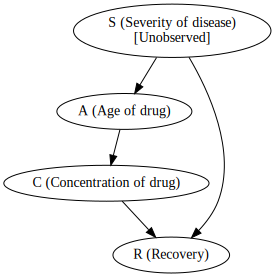

In [2]:
G = nx.DiGraph()
C, R, A, S = 'C (Concentration of drug)', 'R (Recovery)', 'A (Age of drug)', 'S (Severity of disease)\n[Unobserved]'
G.add_edge(S, A)
G.add_edge(S, R)
G.add_edge(C, R)
G.add_edge(A, C)

draw(G)

**Answer (b)**: Let's construct a structural causal model to generate a dataset that exhibits the reversal seen in the original, then use that to construct a data set. Here 75% of the population has mild disease. People with mild disease are buy the cheap drug 90% of the time, while people with severe disease buy the expensive drug 90% of the time. The drug helps both people with mild disease and severe disease.

In [3]:
import random
import numpy as np
from typing import NamedTuple

class datapoint(NamedTuple):
    age: str
    concentration: str
    severity: str
    recovery: str
    
new = 'new'
old = 'old'
severe = 'severe'
mild = 'mild'
high_concentration = 'high'
low_concentration = 'low'
recovered = 'recovered'
not_recovered = 'not recovered'

def get_sample(N=1000):
    def get_concentration(age):
        if age == old:
            return high_concentration if random.random() < 0.05 else low_concentration
        else:
            return low_concentration if random.random() < 0.05 else high_concentration
    def get_age(severity):
        if severity == mild:
            return old if random.random() <= 0.9 else new
        else:
            return new if random.random() <= 0.9 else old
    def get_recovery(severity, concentration):
        if severity == severe and concentration == high_concentration:
            return recovered if random.random() < 0.2 else not_recovered
        elif severity == severe and concentration == low_concentration:
            return recovered if random.random() < 0.05 else not_recovered
        if severity == mild and concentration == high_concentration:
            return recovered if random.random() < 0.9 else not_recovered
        elif severity == mild and concentration == low_concentration:
            return recovered if random.random() < 0.4 else not_recovered
        else:
            assert False
        
    def get_row(severity):
        age = get_age(severity)
        concentration = get_concentration(age)
        recovery = get_recovery(severity, concentration)
        return datapoint(
            age=age,
            concentration=concentration,
            recovery=recovery,
            severity=severity
        )
    results = [get_row('mild') for _ in range(int(N * 0.75))] + [get_row('severe') for _ in range(N - int(N * 0.75))]
    random.shuffle(results)
    return results

sample = get_sample(200000)

In [4]:
from collections import Counter
joint_counts = Counter(sample)
total = sum(joint_counts.values())
joint_dist = {point: count / total for point, count in sorted(joint_counts.items())}
print(joint_dist)

{datapoint(age='new', concentration='high', severity='mild', recovery='not recovered'): 0.00717, datapoint(age='new', concentration='high', severity='mild', recovery='recovered'): 0.064705, datapoint(age='new', concentration='high', severity='severe', recovery='not recovered'): 0.17205, datapoint(age='new', concentration='high', severity='severe', recovery='recovered'): 0.042275, datapoint(age='new', concentration='low', severity='mild', recovery='not recovered'): 0.00221, datapoint(age='new', concentration='low', severity='mild', recovery='recovered'): 0.001515, datapoint(age='new', concentration='low', severity='severe', recovery='not recovered'): 0.010085, datapoint(age='new', concentration='low', severity='severe', recovery='recovered'): 0.000485, datapoint(age='old', concentration='high', severity='mild', recovery='not recovered'): 0.00351, datapoint(age='old', concentration='high', severity='mild', recovery='recovered'): 0.0299, datapoint(age='old', concentration='high', severity

In [5]:
from typing import *
from collections import defaultdict
def P(*variables: List[str], joint_dist=joint_dist, **given):
    """
    e.g. P("sprinkler", "slippery", wet=0, season=1) = P(sprinkler, slippery|wet=0, season=1)
    
    Returns a joint distribution on the list of variables, given that `given` is the case.
    """
    Event = NamedTuple('Event', [(variable, Any) for variable in variables])
    p_given = 0.0
    conditional_dist = defaultdict(float)
    for event, prob in joint_dist.items():
        if all(getattr(event, k) == v for k, v in given.items()):
            p_given += prob
            c = Event(*[getattr(event, var) for var in variables])
            conditional_dist[c] += prob
    return {
        c: prob / p_given for c, prob in conditional_dist.items()
    }


print(f"{P('recovery', age=new)=}")
print(f"{P('recovery', age=old)=}")


P('recovery', age=new)={Event(recovery='not recovered'): 0.6373317359689845, Event(recovery='recovered'): 0.36266826403101543}
P('recovery', age=old)={Event(recovery='not recovered'): 0.5883160234737422, Event(recovery='recovered'): 0.4116839765262578}


<hr>

(c) Determine the effect of choosing the fresh versus the aged drug by using assumptions (i) and (ii) and that data given in (b).

**Answer (c)**

The causal graph from (a) is the same as the smoking/tar/cancer graph, so clearly satisfies the front-door condition, with the following assignments for XYZ:

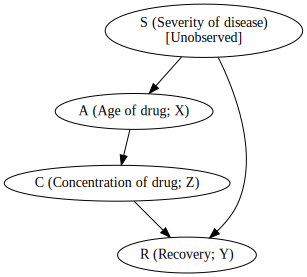

In [6]:
G = nx.DiGraph()
C, R, A, S = 'C (Concentration of drug; Z)', 'R (Recovery; Y)', 'A (Age of drug; X)', 'S (Severity of disease)\n[Unobserved]'
G.add_edge(S, A)
G.add_edge(S, R)
G.add_edge(C, R)
G.add_edge(A, C)

draw(G)

Now we can compute:

$$ P(y|do(x)) = \sum_z \left(P(z|x)\sum_{x'\neq x} P(y|x',z)P(x')\right) $$

In [16]:
AGES = [old, new]  # X
CONCENTRATIONS = [high_concentration, low_concentration]  # Z
RECOVERIES = [recovered, not_recovered] # Y
 
def front_door_dist(age) -> dict:
    """
    Computes P(R|do(A=age)) using the front-door criterion.
    """
    dist = {}
    for recovery in RECOVERIES:
        acc = 0.0
        for concentration in CONCENTRATIONS:
            p_conc_given_age = P("concentration", age=age)[(concentration, )]
            sub_sum = 0.0
            for other_age in AGES:
                p_other_age = P("age")[(other_age, )]
                p_recovery_given_other_age_and_conc = P("recovery",
                                                        age=other_age,
                                                        concentration=concentration)[(recovery, )]
                sub_sum += p_other_age * p_recovery_given_other_age_and_conc
            acc += sub_sum * p_conc_given_age
        dist[recovery] = acc
    return dist


print(f'{front_door_dist(old)=}')
print(f'{front_door_dist(new)=}')

front_door_dist(old)={'recovered': 0.33349685777117566, 'not recovered': 0.6665031422288245}
front_door_dist(new)={'recovered': 0.7013607837140019, 'not recovered': 0.2986392162859981}


Is this what we'd expect analytically? Given that we have the structural causal model, we can compute the exact probabilities.

Recall the SCM used to generate the data:
```python
def get_sample(N=1000):
    def get_concentration(age):
        if age == old:
            return high_concentration if random.random() < 0.05 else low_concentration
        else:
            return low_concentration if random.random() < 0.05 else high_concentration
    def get_age(severity):
        if severity == mild:
            return old if random.random() <= 0.9 else new
        else:
            return new if random.random() <= 0.9 else old
    def get_recovery(severity, concentration):
        if severity == severe and concentration == high_concentration:
            return recovered if random.random() < 0.2 else not_recovered
        elif severity == severe and concentration == low_concentration:
            return recovered if random.random() < 0.05 else not_recovered
        if severity == mild and concentration == high_concentration:
            return recovered if random.random() < 0.9 else not_recovered
        elif severity == mild and concentration == low_concentration:
            return recovered if random.random() < 0.4 else not_recovered
        else:
            assert False
        
    def get_row(severity):
        age = get_age(severity)
        concentration = get_concentration(age)
        recovery = get_recovery(severity, concentration)
        return datapoint(
            age=age,
            concentration=concentration,
            recovery=recovery,
            severity=severity
        )
    results = [get_row('mild') for _ in range(int(N * 0.75))] + [get_row('severe') for _ in range(N - int(N * 0.75))]
    random.shuffle(results)
    return results
```

### Probability of recovering given old medicine:
\begin{aligned}
P\left(R=\textrm{recovered}|do(A=\textrm{new})\right) =& P(mild, recovered, high|new) + P(mild, recovered, low|new)\\
&  + P(severe, recovered, high|new) + P(severe, recovered, low|new) \\
 =& (0.75\cdot 0.9 \cdot 0.95) + (0.75\cdot 0.4 \cdot 0.05) + (0.25\cdot 0.2\cdot 0.95) + (0.25\cdot 0.05 \cdot 0.05) \\
 =& 0.704375 \\
P\left(R=\textrm{recovered}|do(A=\textrm{old})\right) =& P(mild, recovered, high|old) + P(mild, recovered, low|old)\\
&  + P(severe, recovered, high|old) + P(severe, recovered, low|old) \\
 =& (0.75\cdot 0.9 \cdot 0.05) + (0.75\cdot 0.4 \cdot 0.95) + (0.25\cdot 0.2\cdot 0.05) + (0.25\cdot 0.05 \cdot 0.95) \\
 =&  0.333125 \\
\end{aligned}

These match the computed values from the front-door criterion fairly closely, suggesting the computations were correct.

In [17]:
(0.75*0.9*0.95)+(0.75*0.4*0.05)+(0.25*0.2*0.95)+(0.25*0.05*0.05)

0.704375

In [18]:
(0.75* 0.9 * 0.05) + (0.75* 0.4 * 0.95) + (0.25* 0.2* 0.05) + (0.25* 0.05 * 0.95)

0.33312500000000006